In [1]:
import sys
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir, Ridge, Input,ESN
from reservoirpy.nodes.activations import Sigmoid
import numpy as np
import reservoirpy
reservoirpy.set_seed(42)
np.random.seed(42)

In [2]:
channel =[0.3040, 0.9030, 0.3040]
train_num_samples=5000
test_num_samples=500
lr=0.1   # leaky integration rate
sr=0.9   # spectral radius
steps=2   #sliding window length

In [3]:
from reservoirpy.mat_gen import uniform,generate_input_weights
W = uniform(50,50, low=-1, high=1, connectivity=0.1, sr=0.9)           # weights of the reservoir
Win = generate_input_weights(50,steps,dist="uniform",connectivity=0.1)  # inputs weights

In [4]:
# W.toarray()

In [5]:
# Win.toarray()

In [6]:
import numpy as np
from functools import partial

def apply_nonlinear(f:str,v_k):
    """
    @param f: specifies whether to modify the input v_k
    @param v_k: input after channel convolution
    """
    if f == None:
        v_k = v_k
    elif f == 'tanh':
        v_k = np.tanh(v_k)
    
    elif f =='poly':
        v_k = v_k +0.2*np.power(v_k,2) - 0.1*np.power(v_k,3)

    return v_k


def generate_noise(db:int,len_sequence:int):
    """
    Generate white noise based on db
    @param db: signal to noise ratio
    @param len_sequence: sequence length of input
    
    """
    
    target_noise_watts = 10**(-db/10)
    return np.random.normal(0,np.sqrt(target_noise_watts),len_sequence)


class EsnDataset():
    def __init__(self,
                 num_samples:int,
                 steps:int,
                 channel:list,
                 db:int=15)->None:
        """
        @param num_samples: sequence length to be generated
        @param steps : sliding window length
        @param channel: channel
        @param db: signal to noise ratio
        """
        self.num_samples = num_samples
        self.channel=channel
        self.steps=steps
        self.db = db
        
    
    def generate_sequence(self):
        """
        Generate random sequence of binary bits
        """
        pure_signal = np.random.choice((0,1),(self.num_samples))

        """
        Apply a convolution to the signal using a channel
        """
        conv_=np.convolve(self.channel,pure_signal,mode='same')
        """
        Apply white noise
        """
        white_noise = generate_noise(self.db,self.num_samples) 
        """
        Apply non linearity
        """
        noisy_signal = apply_nonlinear('tanh',conv_)+white_noise
        
        return noisy_signal,pure_signal
    
    def sliding_window(self,lst:np.array,steps:int)->np.array:
        """
        Function to generate a sliding window
        """
        p=[]
        lst = lst.tolist()
        lst = list(reversed(lst))
        for i in range(len(lst)-(steps-1)):
            p.append(list(reversed(lst[i:i+steps])))
        return np.array(p)
    
    def generate_data_sliding_window(self,pure_signal,noisy_signal):
        pure_signal = self.sliding_window(pure_signal,self.steps)
        noisy_signal = self.sliding_window(noisy_signal,self.steps)   
        return noisy_signal,pure_signal
    
    def __getitem__(self,idx):
        noisy_sequence,pure_sequence = self.generate_sequence()
        noisy_signal,pure_signal=self.generate_data_sliding_window(pure_sequence,noisy_sequence)

        return noisy_sequence,\
                pure_sequence,\
                noisy_signal[idx*self.num_samples:(idx+1)*self.num_samples][None,:,:],\
                pure_signal[idx*self.num_samples:(idx+1)*self.num_samples][:,-1][:,None]

In [27]:
train_data = EsnDataset(num_samples=train_num_samples,steps=steps,channel=channel)
test_data = EsnDataset(num_samples=test_num_samples,steps=steps,channel=channel)

In [28]:
train_sequence_x,train_sequence_y,train_x,train_y=iter(train_data).__next__()
test_sequence_x,test_sequence_y,test_x,test_y=iter(test_data).__next__()

In [29]:
train_x.shape,train_y.shape

((1, 4999, 2), (4999, 1))

In [30]:
test_x.shape,test_y.shape

((1, 499, 2), (499, 1))

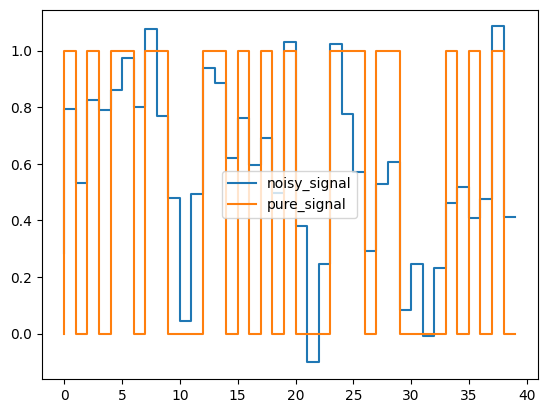

In [31]:
plt.step(np.arange(len(train_sequence_x[:40])),train_sequence_x[:40])
plt.step(np.arange(len(train_sequence_y[:40])),train_sequence_y[:40])
plt.legend(['noisy_signal','pure_signal'])

In [32]:
esn = ESN(lr=0.3,W=W,Win=Win,ridge = 1e-6)
esn.fit(train_x,train_y)

Running ESN-1: 100%|██████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

Fitting node ESN-1...


'ESN-1': ESN('Reservoir-1', 'Ridge-1')

In [33]:
pred=esn.run(test_x)

Running ESN-1: 100%|██████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


In [34]:
((pred-test_y)**2).mean()/len(pred)

0.0002169463673766625

In [35]:
# units = 50
# leak_rate = 0.3
# spectral_radius = 0.9
# input_scaling = 1.0
# connectivity = 0.1
# input_connectivity = 0.1
# seed = 1234

In [36]:
# from reservoirpy.nodes import FORCE

# reservoir = Reservoir(
#                       input_scaling=input_scaling,\
#                       sr=spectral_radius,
#                       lr=leak_rate, 
# #                       ?rc_connectivity=connectivity,
#                       input_connectivity=input_connectivity, 
#                       Win=Win,
#                       W=W,
#                       seed=seed)

# readout   = FORCE(1)


# esn_online = reservoir >> readout